In [1]:
%load_ext autoreload
%autoreload 2

In [69]:
import pandas as pd
import numpy as np
import yfinance as yf
import plotly.graph_objects as go
import plotly.express as px
import datetime
from utils import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error, r2_score

In [115]:
ticker = yf.Ticker('^GSPC')
df = ticker.history(period='max', interval='1d')

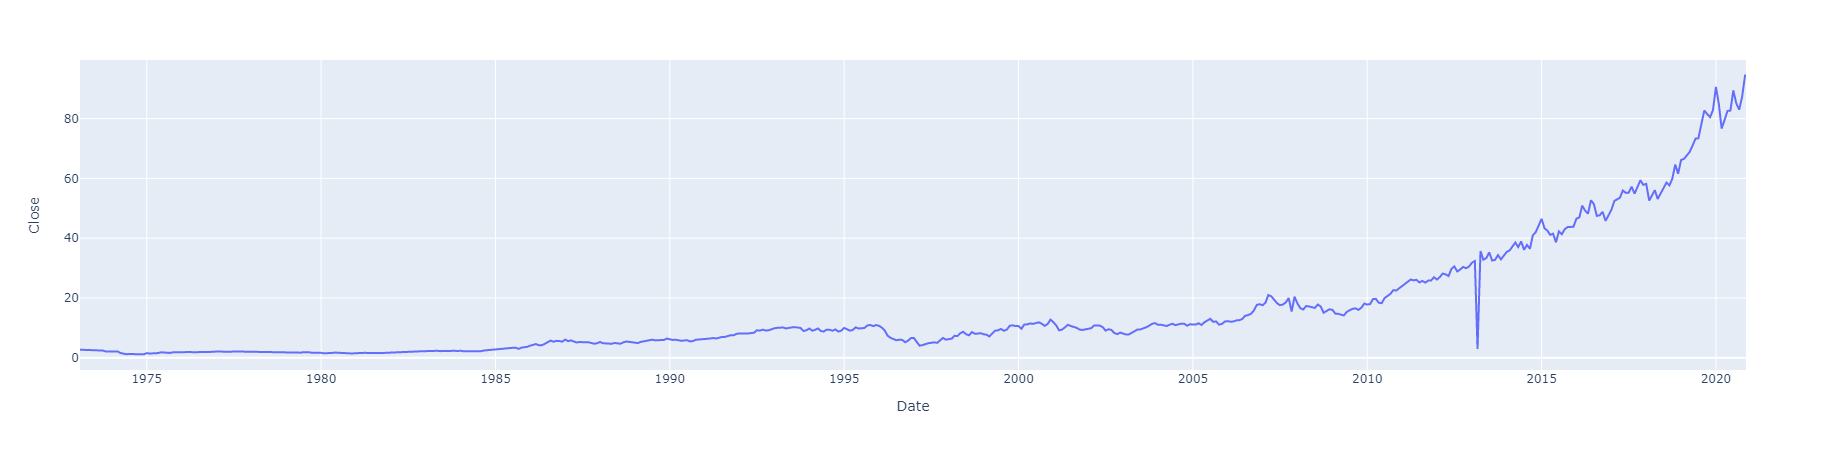

In [114]:
px.line(ticker.history(period='max', interval='1mo').reset_index().dropna(), x='Date', y='Close')

In [116]:
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
df['Date'] = df.index
df['price'] = df['Close']

In [117]:
df = df.reindex(index=pd.date_range(df.index[0], df.index[-1])).ffill().bfill()

In [118]:
df = df['2019-01-01':]

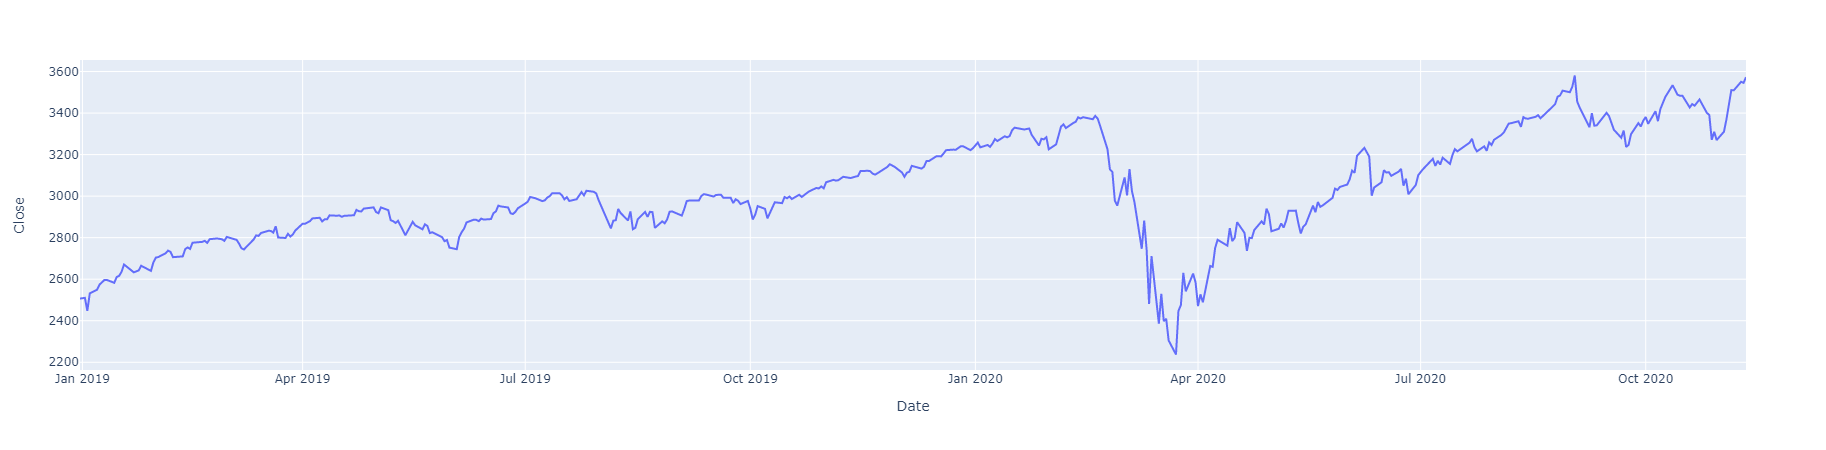

In [119]:
px.line(df, x='Date', y='Close')

In [120]:
from forecasting.fourier import Fourier
from forecasting.wavelet import Wavelet
from forecasting.lstm import LSTM
from forecasting.baseline import Baseline
from forecasting.stacking import Stacking

from forecasting.arima import fit_model, predict_model, update_model, arima_predict_for_report

In [121]:
def _plot_forecast_to_future(df, preds):
    main_price = go.Scatter(
        x=df.index,
        y=df['Close'],
        name='Исторические данные'
    )
    pred_plots = []
    for column in preds.columns:
        pred_plots.append(go.Scatter(
            x=preds.index,
            y=preds[column],
            name=column
        ))
    return go.Figure(data=[main_price, *pred_plots])

def plot_forecast_to_future(df, preds):
    _plot_forecast_to_future(df, preds).show()

In [122]:
def _plot_train_test_predict(train, test, preds):
    train_plot = go.Scatter(x=train.index, y=train.Close, name='Исторические данные')
    test_plot = go.Scatter(x=test.index, y=test.Close, name='Тест')
    pred_plots = []
    for column in preds.columns:
        pred_plots.append(go.Scatter(
            x=preds.index,
            y=preds[column],
            name=column
        ))
    return go.Figure(data=[train_plot, test_plot, *pred_plots])

def plot_train_test_predict(train, test, preds):
    _plot_train_test_predict(train, test, preds).show()

In [123]:
def get_all_models(df, n_pred):
    model_fourier = Fourier(df, n_harm=100, trend_deg=1, n=n_pred)
    model_wavelet = Wavelet(df, n=n_pred)
    model_baseline = Baseline(n=n_pred)

    models = {
        'fourier': model_fourier, 
        'wavelet': model_wavelet,
        'baseline': model_baseline
    }
    return models

In [124]:
def predict_all_models(models):
    preds = {model: models[model].predict(df_train) for model in models.keys()}
    return pd.DataFrame(preds)

In [125]:
def get_all_reports(models, window_size):
    reports = []
    for model in models.keys():
        date_start = df_train['Date'][-window_size].strftime('%Y-%m-%d')
        date_end = df_train['Date'][-1].strftime('%Y-%m-%d')
        report = models[model].predict_for_report(df_train[:date_end], date_start, date_end)
        reports.append(report)
    return reports

In [126]:
def predict_stacking(df, reports):
    model = Stacking(df_train, *reports, verbose=True)
    return model.predict(preds)

In [127]:
def print_results(preds, metric=mean_absolute_error):
    for pred in preds.keys():
        print(f"{pred}: {metric(df_test['Close'], preds[pred])}")

In [128]:
n_pred = 30

df_train = df.iloc[:-n_pred]
df_test = df.iloc[-n_pred:]

In [129]:
models = get_all_models(df_train, n_pred)
preds = predict_all_models(models)
reports = get_all_reports(models, n_pred * 5)

In [130]:
preds['stacking'] = predict_stacking(df_train, reports)
preds['Date'] = pd.date_range(df_test['Date'][0], periods=n_pred)
preds = preds.set_index('Date')

In [131]:
model = fit_model(df_train[['price', 'Open']], n_pred)
preds['arima'] = predict_model(model, df_train[['price', 'Open']], n_pred)

C:\Anaconda\envs\dev\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Anaconda\envs\dev\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Anaconda\envs\dev\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Anaconda\envs\dev\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Anaconda\envs\dev\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Anaconda\envs\dev\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Che

fourier: 4.944846834747024
wavelet: 2.8669041358240106
baseline: 3.0283257912643187
stacking: 2.768973926086364
arima: 3.203584007747469


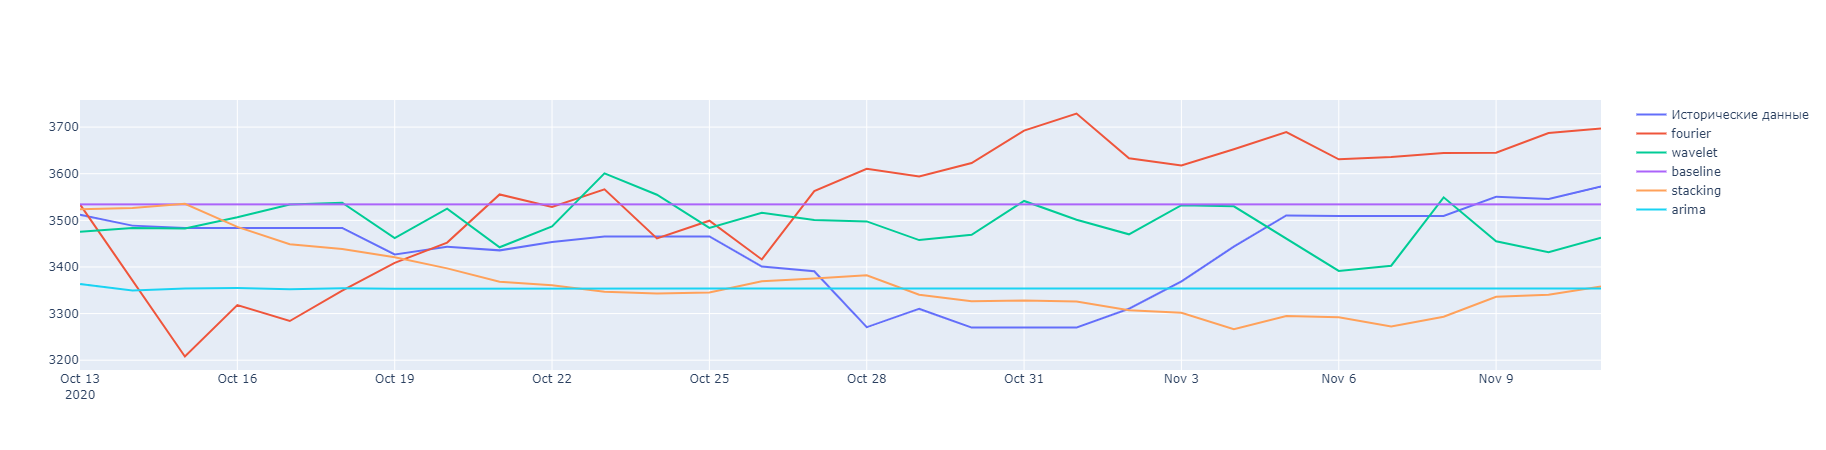

In [134]:
print_results(preds, metric=mean_absolute_percentage_error)
plot_forecast_to_future(df_test, preds)

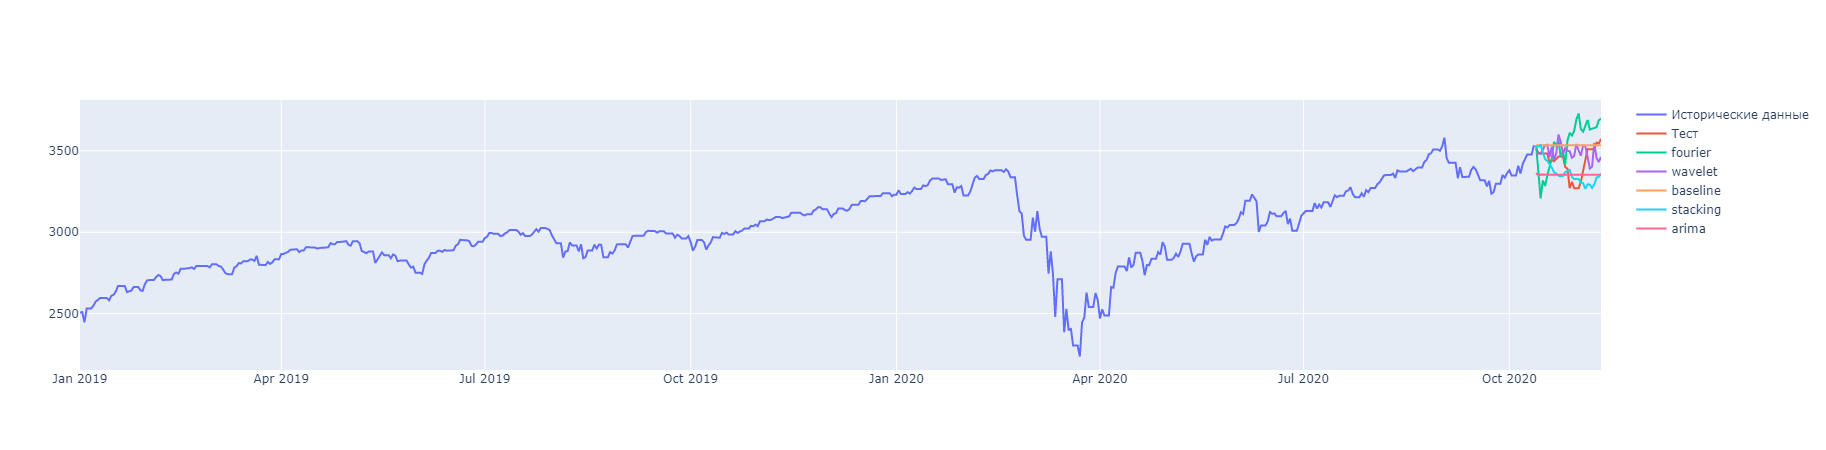

In [133]:
plot_train_test_predict(df_train, df_test, preds)

In [91]:
!telegram-send Посчиталось!